## GARCH Volatility Modeling
### Analysis of S&P 500 Volatility Dynamics

This notebook demonstrates advanced volatility modeling techniques using GARCH models
applied to S&P 500 data. We progress from basic univariate GARCH to sophisticated
multivariate models. Lastly, we'll compile for risk management applications. 

Key Analyses:
1. Univariate GARCH modeling and diagnostics
2. Dynamic Conditional Correlation (DCC-GARCH) for multi-asset portfolios
3. Regime-switching GARCH for crisis detection
4. Risk management applications (VaR, portfolio optimization)

------------------------------------------------------------------------------------------------------

#### 1. Setup and Data Preparation

##### Import Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from arch import arch_model
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')

##### Set Style

In [2]:
# Set style for professional plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
print("="*22, "ADVANCED GARCH VOLATILITY MODELING", "="*22)
print("Analyzing S&P 500 volatility dynamics using sophisticated econometric models")
print("=" * 80)

====================== ADVANCED GARCH VOLATILITY MODELING ======================
Analyzing S&P 500 volatility dynamics using sophisticated econometric models


In [4]:
# Define the date range for data retrieval
start_date = '2019-10-04'
filter_date = '2020-01-01'
end_date = '2024-12-31'
# Define tickers for multi-asset analysis
tickers = {
        'SPY': 'S&P 500 ETF',
        'TLT': '20+ Year Treasury ETF', 
        'GLD': 'Gold ETF',
        'VXX': 'Volatility S&P 500 Index ETF'
    }

In [5]:
def load_market_data(tickers, start_date, end_date):
    """
    Load market data for specified tickers within a date range.
    Returns a DataFrame with adjusted close prices.
    """
    #print(f"Loading market data from {start_date} to {end_date}") <--Not sure I need to print this
    # Load market data
    data = {}
    for ticker, name in tickers.items():
        #print(f"Retrieving data for {name} ({ticker})") <-- Not sure I need to print this
        temp_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        data[ticker] = pd.Series(temp_data['Close'][ticker][:], index=temp_data.index)
        #print(f"Loaded {ticker} ({name}): {len(tickers)} observations") <-- Not sure I need to print this
    
    prices_df = pd.DataFrame.from_dict(data, orient='index').T
    returns_df = prices_df.pct_change().dropna() * 100  # Convert to percentage
    sp500_returns = returns_df['SPY']
    return prices_df, returns_df, sp500_returns

In [6]:
prices, returns, sp500_returns_ = load_market_data(tickers, start_date, end_date)

In [7]:
#filter out first 60 days - will use in multivariate GARCH model and correlations analysis
prices_df = prices[prices.index >= filter_date]
returns_df = returns[returns.index >= filter_date]
sp500_returns = sp500_returns_[sp500_returns_.index >= filter_date]

#### 2. S&P Summary Statistics and Exploratory Data Analysis

##### S&P 500 Summary Analysis

In [8]:
print("\n" + "="*50)
print("SECTION 2: Summary Statistics and Visualizations")
print("="*50)


SECTION 2: Summary Statistics and Visualizations


In [9]:
print(f"\nS&P 500 Returns Summary Statistics:")
print(f"Mean: {sp500_returns.mean():.4f}%")
print(f"Std Dev: {sp500_returns.std():.4f}%")
print(f"Skewness: {sp500_returns.skew():.4f}")
print(f"Kurtosis: {sp500_returns.kurtosis():.4f}")
print(f"Min: {sp500_returns.min():.4f}%")
print(f"Max: {sp500_returns.max():.4f}%")


S&P 500 Returns Summary Statistics:
Mean: 0.0628%
Std Dev: 1.3229%
Skewness: -0.5443
Kurtosis: 11.5024
Min: -10.9424%
Max: 9.0603%


In [10]:
#Function Function to plot explroatory analysis and review results
def create_exploratory_plots(returns, prices):
    """
    Create comprehensive exploratory data analysis plots
    """
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Price evolution
    plt.subplot(3, 2, 1)
    prices['SPY'].plot(title='S&P 500 Price Evolution', color='blue')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    
    # 2. Returns time series
    plt.subplot(3, 2, 2)
    returns.plot(title='S&P 500 Daily Returns', color='red', alpha=0.7)
    plt.ylabel('Returns (%)')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    
    # 3. Returns distribution
    plt.subplot(3, 2, 3)
    returns.hist(bins=50, density=True, alpha=0.7, color='green')
    
    # Overlay normal distribution
    x = np.linspace(returns.min(), returns.max(), 100)
    normal_dist = stats.norm.pdf(x, returns.mean(), returns.std())
    plt.plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    plt.title('Returns Distribution vs Normal')
    plt.xlabel('Returns (%)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Q-Q plot
    plt.subplot(3, 2, 4)
    stats.probplot(returns, dist="norm", plot=plt)
    plt.title('Q-Q Plot: Returns vs Normal Distribution')
    plt.grid(True, alpha=0.3)
    
    # 5. Rolling volatility
    plt.subplot(3, 2, 5)
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
    rolling_vol.plot(title='30-Day Rolling Volatility (Annualized)', color='purple')
    plt.ylabel('Volatility (%)')
    plt.grid(True, alpha=0.3)
    
    # 6. Autocorrelation of squared returns
    plt.subplot(3, 2, 6)

    squared_returns = returns**2
    acf_values = acf(squared_returns, nlags=20, fft=True)
    plt.bar(range(len(acf_values)), acf_values, alpha=0.7)
    plt.title('ACF of Squared Returns (Volatility Clustering)')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    print("\n" + "="*50)
    print("STATISTICAL TESTS")
    print("="*50)
    
    # Normality test
    jb_stat, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(returns)
    print(f"Jarque-Bera Test for Normality:")
    print(f"  Statistic: {jb_stat:.4f}")
    print(f"  P-value: {jb_pvalue:.6f}")
    print(f"  Result: {'Reject normality' if jb_pvalue < 0.05 else 'Cannot reject normality'}")
    
    # ARCH test (volatility clustering)
    lb_test = acorr_ljungbox(squared_returns, lags=10, return_df=True)
    print(f"\nLjung-Box Test for ARCH Effects (Volatility Clustering):")
    print(f"  P-value (lag 10): {lb_test['lb_pvalue'].iloc[-1]:.6f}")
    print(f"  Result: {'Significant ARCH effects detected' if lb_test['lb_pvalue'].iloc[-1] < 0.05 else 'No ARCH effects'}")



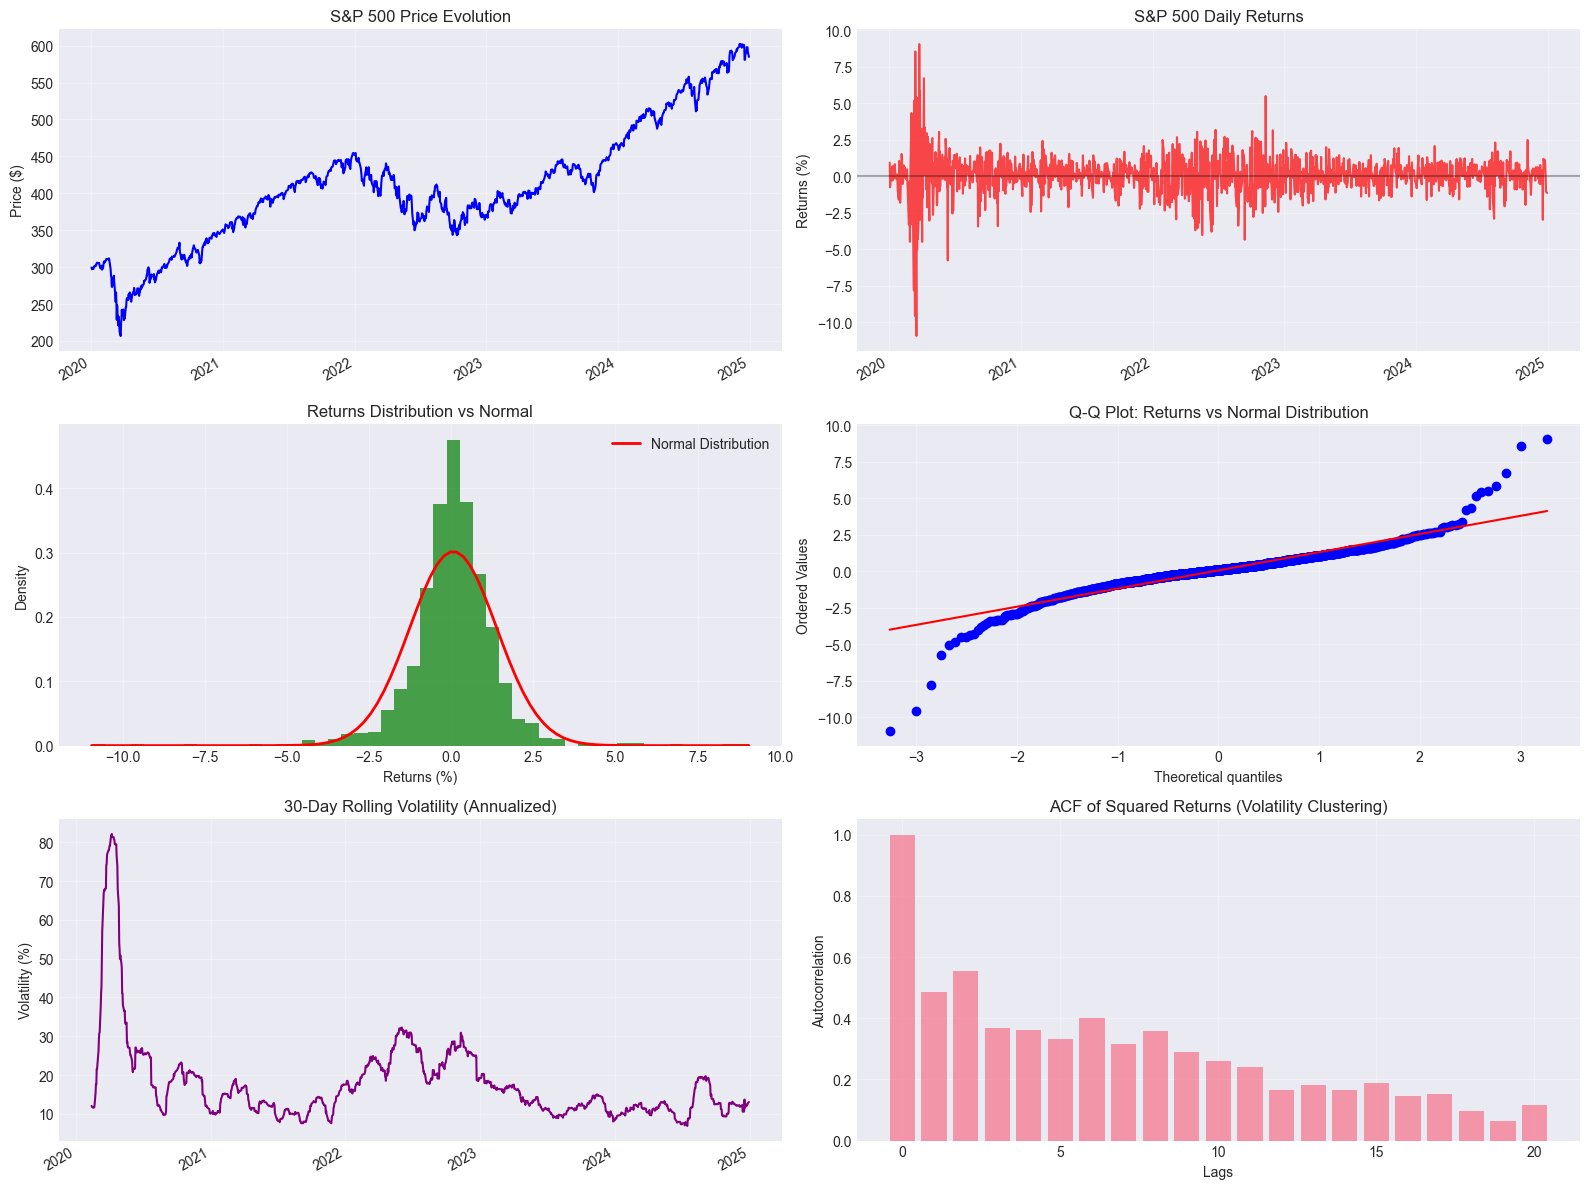


STATISTICAL TESTS
Jarque-Bera Test for Normality:
  Statistic: 6930.6901
  P-value: 0.000000
  Result: Reject normality

Ljung-Box Test for ARCH Effects (Volatility Clustering):
  P-value (lag 10): 0.000000
  Result: Significant ARCH effects detected


In [11]:
create_exploratory_plots(sp500_returns, prices_df)
#create a writeup : what we're looking at and how this impacts the model going forward
# what the visuals mean and the conclusions that can be drawn from the statistics tests

#### 3. Univariate GARCH Model

In [12]:
print("\n" + "="*50)
print("SECTION 3: UNIVARIATE GARCH MODELING")
print("="*50)


SECTION 3: UNIVARIATE GARCH MODELING


In [13]:
"""
Fit various GARCH specifications and compare
"""
model_specs = {
        'GARCH(1,1)': {'p': 1, 'q': 1, 'dist': 'normal'},
        'GARCH(1,1)-t': {'p': 1, 'q': 1, 'dist': 't'},
        'GARCH(2,2)': {'p': 2, 'q': 2, 'dist': 'normal'},
        'EGARCH(1,1)': {'p': 1, 'q': 1, 'dist': 'normal', 'vol': 'EGARCH'},
        'GJR-GARCH(1,1)': {'p': 1, 'q': 1, 'dist': 'normal', 'vol': 'GARCH', 'o': 1}
        }

In [14]:
# Function compares GARCH models and returns a DataFrame with results
def compare_garch_models(returns, model_specs):
    results_summary = []
    models = {}
    fitted_models = {}

    for name, specs in model_specs.items():
        vol_model = specs.get('vol', 'GARCH')
        model = arch_model(
                    returns, 
                    vol=vol_model, 
                    p=specs['p'], 
                    q=specs['q'],
                    o=specs.get('o', 0),
                    dist=specs['dist']
                    )
                    
        fitted = model.fit(disp='off')
        models[name] = model
        fitted_models[name] = fitted
                    
        # Store key metrics
        results_summary.append({
                    'Model': name,
                    'AIC': fitted.aic,
                    'BIC': fitted.bic,
                    'Log-Likelihood': fitted.loglikelihood,
                    'Parameters': fitted.num_params
                    })

    # Create comparison table
    model_comparison = pd.DataFrame(results_summary)
    model_comparison = model_comparison.sort_values('AIC')
            
    # Select best model
    best_model_name = model_comparison.iloc[0]['Model']
    best_model = fitted_models[best_model_name]
            
    return fitted_models, model_comparison, best_model_name, best_model

In [15]:
fitted_models, model_comparison, best_model_name, best_model = compare_garch_models(sp500_returns, model_specs)

In [16]:
print("\nModel Comparison (sorted by AIC):") 
print(model_comparison.to_string(index=False))
print(f"\nBest model: {best_model_name}")


Model Comparison (sorted by AIC):
         Model         AIC         BIC  Log-Likelihood  Parameters
  GARCH(1,1)-t 3614.104256 3639.786672    -1802.052128           5
GJR-GARCH(1,1) 3637.198434 3662.880850    -1813.599217           5
    GARCH(1,1) 3658.670346 3679.216278    -1825.335173           4
    GARCH(2,2) 3660.993990 3691.812889    -1824.496995           6
   EGARCH(1,1) 3669.637135 3690.183068    -1830.818568           4

Best model: GARCH(1,1)-t


In [17]:
def model_diagnostics(model_name):
        """
        Comprehensive model diagnostics
        """
        if model_name is None:
            model_name = best_model_name
        
        fitted_model = fitted_models[model_name]
        
        print(f"\n{'='*60}")
        print(f"MODEL DIAGNOSTICS: {model_name}")
        print(f"{'='*60}")
        print(fitted_model.summary())
        
        # Extract residuals
        std_residuals = fitted_model.std_resid
        conditional_vol = fitted_model.conditional_volatility
        
        # Create diagnostic plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle(f'GARCH Model Diagnostics: {model_name}', fontsize=16)
        
        # 1. Standardized residuals over time
        axes[0, 0].plot(std_residuals, alpha=0.7)
        axes[0, 0].set_title('Standardized Residuals')
        axes[0, 0].set_ylabel('Std. Residuals')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Conditional volatility
        axes[0, 1].plot(conditional_vol * np.sqrt(252), color='red')  # Annualized
        axes[0, 1].set_title('Conditional Volatility (Annualized)')
        axes[0, 1].set_ylabel('Volatility (%)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Residuals distribution
        axes[0, 2].hist(std_residuals, bins=50, density=True, alpha=0.7)
        x = np.linspace(std_residuals.min(), std_residuals.max(), 100)
        axes[0, 2].plot(x, stats.norm.pdf(x), 'r-', linewidth=2, label='Normal')
        axes[0, 2].set_title('Standardized Residuals Distribution')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Q-Q plot
        stats.probplot(std_residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot: Residuals vs Normal')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. ACF of standardized residuals
        acf_resid = acf(std_residuals, nlags=20, fft=True)
        axes[1, 1].bar(range(len(acf_resid)), acf_resid, alpha=0.7)
        axes[1, 1].set_title('ACF of Standardized Residuals')
        axes[1, 1].set_xlabel('Lags')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. ACF of squared standardized residuals
        acf_resid_sq = acf(std_residuals**2, nlags=20, fft=True)
        axes[1, 2].bar(range(len(acf_resid_sq)), acf_resid_sq, alpha=0.7, color='orange')
        axes[1, 2].set_title('ACF of Squared Std. Residuals')
        axes[1, 2].set_xlabel('Lags')
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical tests on residuals
        print(f"\nResidual Diagnostics:")
        jb_stat, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(std_residuals)
        print(f"Jarque-Bera (normality): {jb_stat:.4f} (p={jb_pvalue:.6f})")
        
        lb_test = acorr_ljungbox(std_residuals**2, lags=10, return_df=True)
        print(f"Ljung-Box on squared residuals (ARCH): {lb_test['lb_pvalue'].iloc[-1]:.6f}")
        
        #return fitted_model


MODEL DIAGNOSTICS: GARCH(1,1)-t
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1802.05
Distribution:      Standardized Student's t   AIC:                           3614.10
Method:                  Maximum Likelihood   BIC:                           3639.79
                                              No. Observations:                 1257
Date:                      Thu, Jul 24 2025   Df Residuals:                     1256
Time:                              23:48:29   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------------------

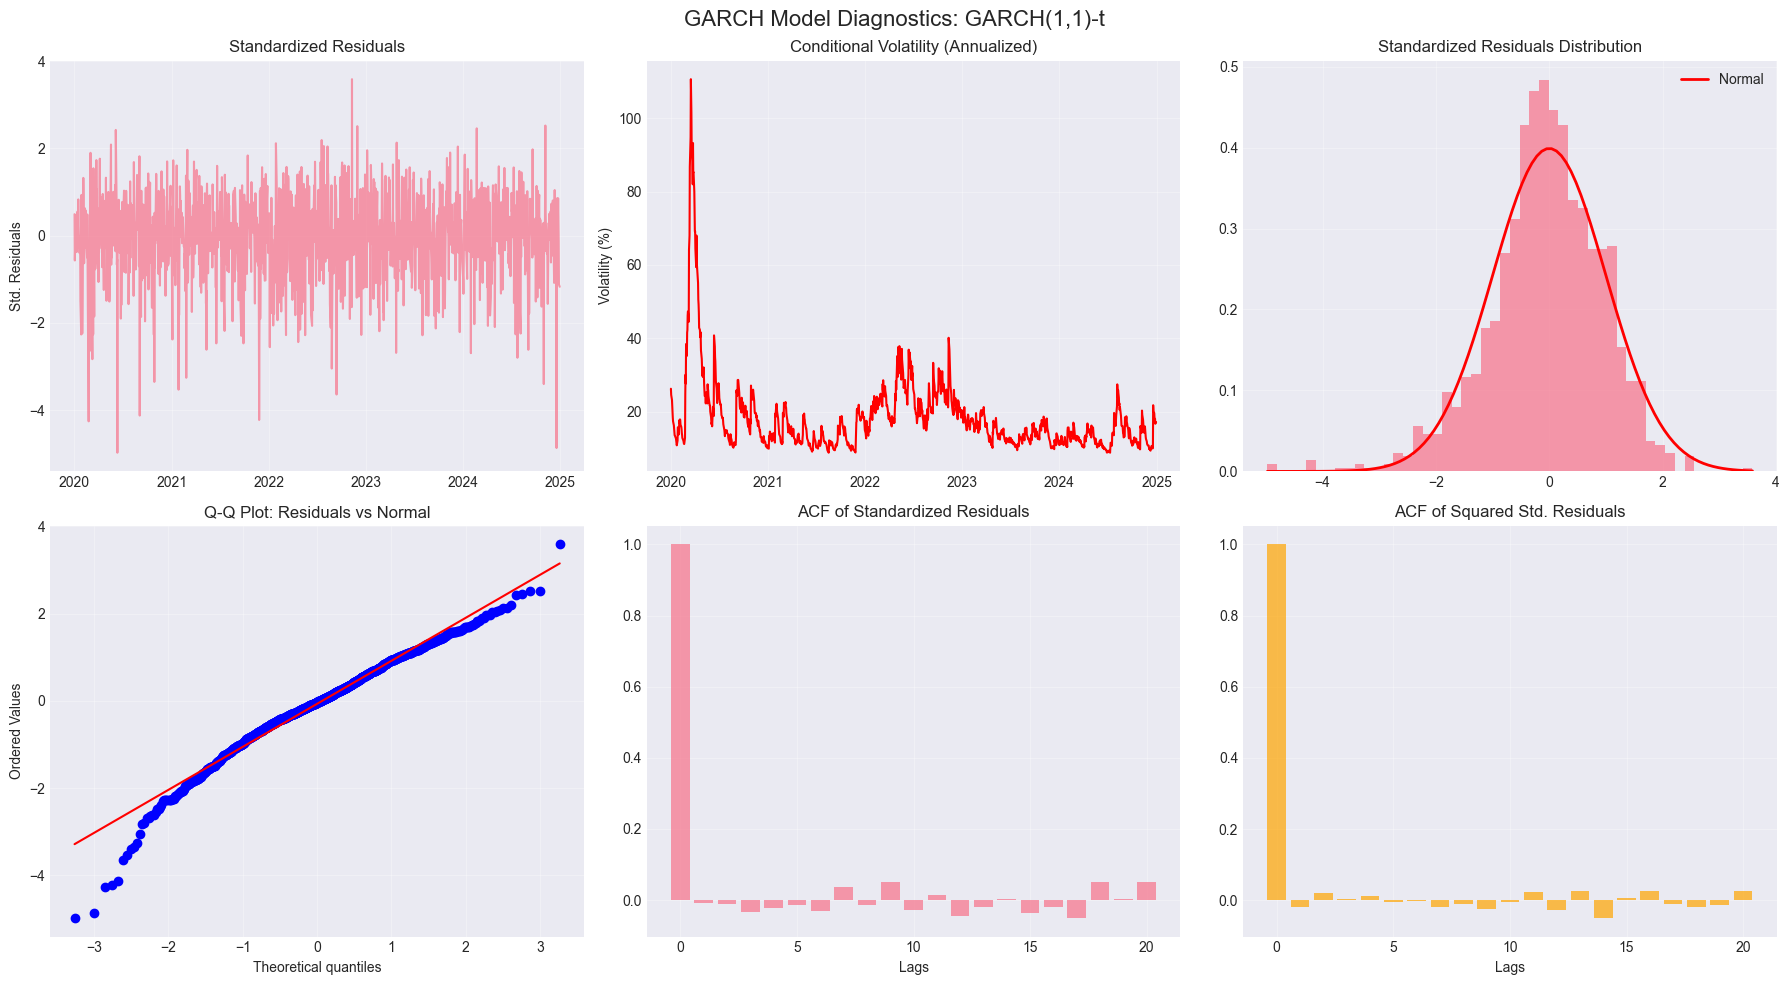


Residual Diagnostics:
Jarque-Bera (normality): 208.4666 (p=0.000000)
Ljung-Box on squared residuals (ARCH): 0.989380


In [18]:
model_diagnostics(best_model_name)
#create a writeup : what we're looking at and how this impacts the model going forward
# what the visuals mean and the conclusions that can be drawn from the statistics tests

#### 4. Multivariate GARCH Model

In [19]:
print("\n" + "="*50)
print("SECTION 4: MULTIVARIATE GARCH MODELING")
print("="*50)


SECTION 4: MULTIVARIATE GARCH MODELING


In [20]:
def create_univariate_models(assets, returns):
    """
    Create univariate GARCH models for each asset in the DataFrame.
    Returns a dictionary of fitted models.
    """
    univariate_models = {}
    for asset in assets:
        model = arch_model(returns[asset], vol='GARCH', p=1, q=1, dist='t')
        fitted = model.fit(disp='off')
        univariate_models[asset] = fitted
    return univariate_models

In [21]:
asset_names = returns_df.columns.tolist()
univariate_models = create_univariate_models(asset_names, returns)

In [22]:
def generate_multivariate_garch_correlations(returns, asset_names, filter_date):
    """
    Manual DCC estimation (simplified version)
    """     
    # Get standardized residuals from univariate models
    std_residuals = pd.DataFrame()
    conditional_vols = pd.DataFrame()
        
    for asset in asset_names:
        std_residuals[asset] = univariate_models[asset].std_resid
        conditional_vols[asset] = univariate_models[asset].conditional_volatility
        
    # Simple DCC estimation using rolling correlation
    window = 60  # 3-month window
    n_assets = len(asset_names)
    n_obs = len(std_residuals)
        
    # Store dynamic correlations
    dynamic_correlations = np.zeros((n_obs, n_assets, n_assets))
        
    # Calculate correlations
    for t in range(window, n_obs):
            # Rolling correlation matrix
            recent_residuals = std_residuals.iloc[t-window:t]
            corr_matrix = recent_residuals.corr().values
            dynamic_correlations[t] = corr_matrix

    """
    Analyze the evolution of correlations over time
    """
    # Extract pairwise correlations
    spy_tlt_corr = [dynamic_correlations[t, 0, 1] for t in range(len(dynamic_correlations))]
    spy_gld_corr = [dynamic_correlations[t, 0, 2] for t in range(len(dynamic_correlations))]
    tlt_gld_corr = [dynamic_correlations[t, 1, 2] for t in range(len(dynamic_correlations))]
        
    # Create DataFrame for analysis
    corr_df = pd.DataFrame({
            'SPY_TLT': spy_tlt_corr,
            'SPY_GLD': spy_gld_corr,
            'TLT_GLD': tlt_gld_corr
        }, index=returns.index)
    corr_df = corr_df[corr_df.index >= filter_date]  # Filter by date
    # Ensure the DataFrame is aligned with the returns index
        
    # Remove initial NaN values
    corr_df = corr_df.dropna()
        
    return corr_df
        

In [23]:
def plot_multivaraite_correlations(corr_df):
    # Plot dynamic correlations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Dynamic Conditional Correlations (DCC-GARCH)', fontsize=16)
            
    # Time series of correlations
    axes[0, 0].plot(corr_df.index, corr_df['SPY_TLT'], label='SPY-TLT', alpha=0.8)
    axes[0, 0].plot(corr_df.index, corr_df['SPY_GLD'], label='SPY-GLD', alpha=0.8)
    axes[0, 0].plot(corr_df.index, corr_df['TLT_GLD'], label='TLT-GLD', alpha=0.8)
    axes[0, 0].set_title('Dynamic Correlations Over Time')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
            
    # Distribution of correlations
    axes[0, 1].hist(corr_df['SPY_TLT'], bins=30, alpha=0.6, label='SPY-TLT')
    axes[0, 1].hist(corr_df['SPY_GLD'], bins=30, alpha=0.6, label='SPY-GLD')  
    axes[0, 1].hist(corr_df['TLT_GLD'], bins=30, alpha=0.6, label='TLT-GLD')
    axes[0, 1].set_title('Distribution of Dynamic Correlations')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
            
    # Crisis periods analysis (high volatility periods)
    vix_data = returns_df['VXX'].loc[corr_df.index]
    high_vix_periods = vix_data > vix_data.quantile(0.8)
            
    axes[1, 0].scatter(vix_data, corr_df['SPY_TLT'], alpha=0.6, s=20)
    axes[1, 0].set_xlabel('VIX Level')
    axes[1, 0].set_ylabel('SPY-TLT Correlation')
    axes[1, 0].set_title('Correlation vs Market Stress (VIX)')
    axes[1, 0].grid(True, alpha=0.3)
            
    # Rolling average correlations
    rolling_corr = corr_df.rolling(window=60).mean()
    axes[1, 1].plot(rolling_corr.index, rolling_corr['SPY_TLT'], label='SPY-TLT (60d avg)')
    axes[1, 1].plot(rolling_corr.index, rolling_corr['SPY_GLD'], label='SPY-GLD (60d avg)')
    axes[1, 1].set_title('60-Day Rolling Average Correlations')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
            
    plt.tight_layout()
    plt.show()
            
    # Crisis analysis
    print(f"\nCorrelation During High VIX Periods (VIX > {vix_data.quantile(0.8):.1f}):")
    crisis_corr = corr_df[high_vix_periods]
    normal_corr = corr_df[~high_vix_periods]
            
    for pair in corr_df.columns:
        crisis_mean = crisis_corr[pair].mean()
        normal_mean = normal_corr[pair].mean()
        print(f"  {pair}: Crisis={crisis_mean:.3f}, Normal={normal_mean:.3f}, Difference={crisis_mean-normal_mean:.3f}")
            
    correlation_df = corr_df

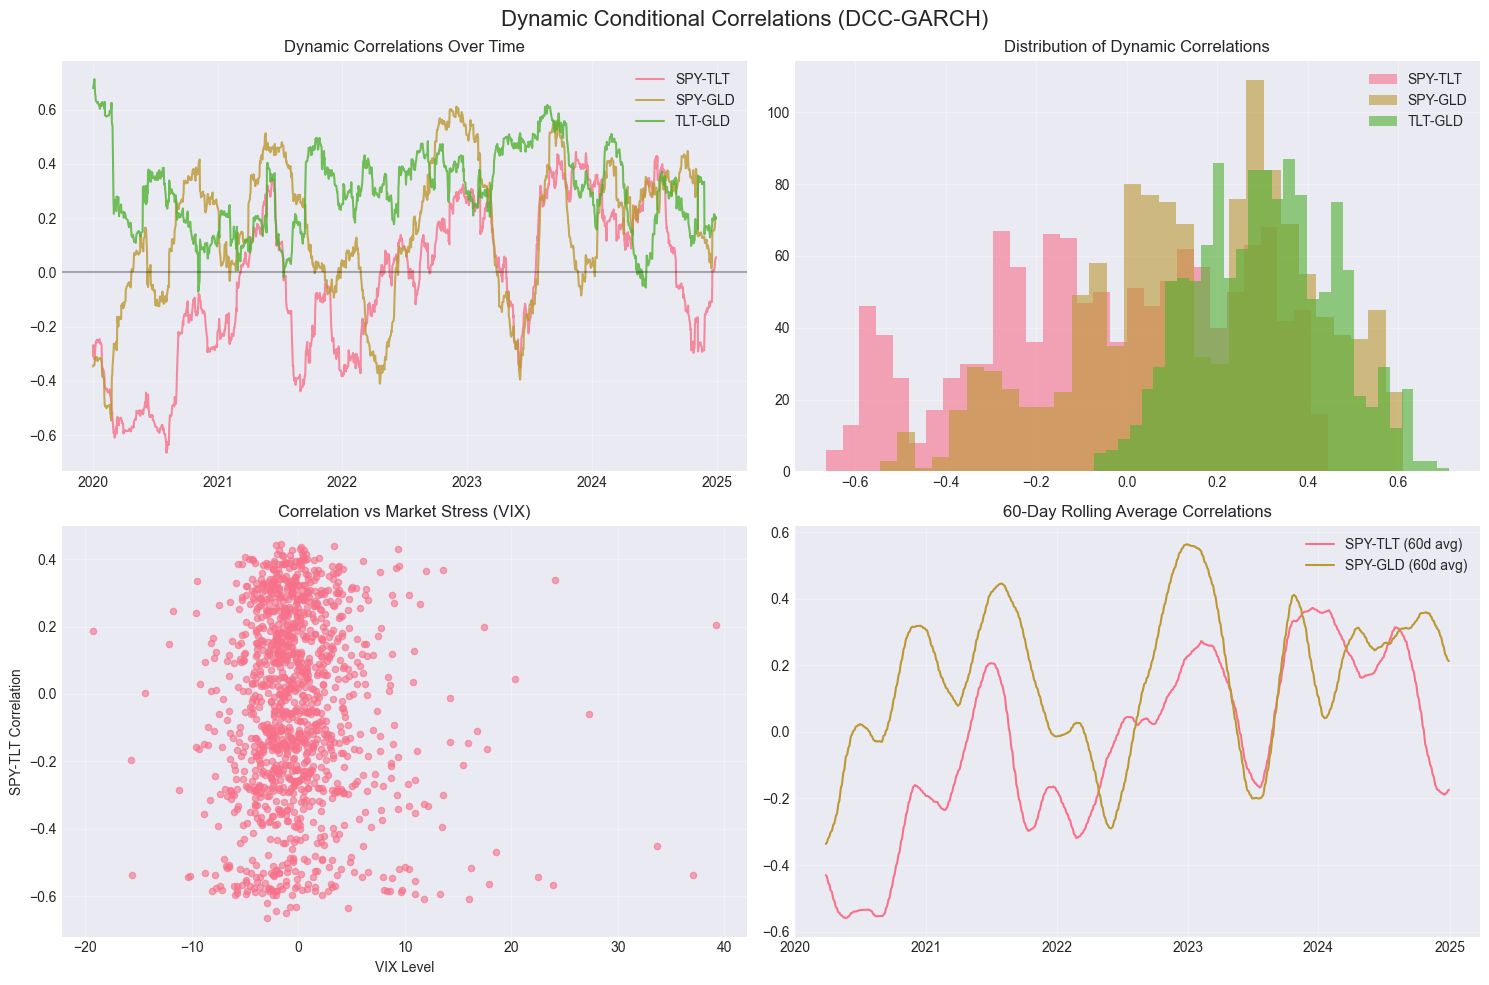


Correlation During High VIX Periods (VIX > 2.4):
  SPY_TLT: Crisis=-0.080, Normal=-0.034, Difference=-0.046
  SPY_GLD: Crisis=0.140, Normal=0.155, Difference=-0.015
  TLT_GLD: Crisis=0.303, Normal=0.304, Difference=-0.001


In [26]:
corr_df = generate_multivariate_garch_correlations(returns, asset_names, filter_date)
plot_multivaraite_correlations(corr_df)
# Create a writeup: what we're looking at and how this impacts the model going forward
# what the visuals mean and the conclusions that can be drawn from the statistics tests

In [ ]:
#use csv data for now - will pull in data via yahoo finance conenction later
# Load S&P 500 data
sp_price = pd.read_csv('data/sp500.csv', index_col='Date', parse_dates=True)

In [ ]:
# Calculate daily returns as percentage price changes
sp_price['Return'] = round(100 * (sp_price['Close'].pct_change()),3)

sp_price['Return'].fillna(-0.324, inplace=True)  # Fill NaN values with 0

# View the data
print(sp_price.head(10))

In [ ]:
# plot the data
plt.plot(sp_price['Return'], color = 'tomato', label = 'Daily Returns')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate daily std of returns
std_daily = sp_price['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

In [ ]:
# Convert daily volatility to monthly volatility
std_monthly = math.sqrt(21) * std_daily
print ('Monthly volatility: ', '{:.2f}%'.format(std_monthly))

# Convert daily volatility to annaul volatility
std_annual = math.sqrt(252) * std_daily
print ('Annual volatility: ', '{:.2f}%'.format(std_annual))

In [ ]:
# Specify GARCH model assumptions
basic_gm = arch_model(sp_price['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

In [ ]:
# Display model fitting summary
print(gm_result.summary())

In [ ]:
# Plot fitted results
gm_result.plot()
plt.show()

In [ ]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

In [ ]:
n_obs = len(gm_result.resid)
normal_resid = np.random.normal(0, 1, n_obs)

In [ ]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid / gm_std

# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins = 50, 
         facecolor = 'orange', label = 'Standardized residuals')
# --> How do I calcualte normal residuals??
plt.hist(normal_resid, bins = 50, 
         facecolor = 'tomato', label = 'Normal residuals')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# Specify GARCH model assumptions
skewt_gm = arch_model(sp_price['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')
# Fit the model
skewt_result = skewt_gm.fit()

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

# Plot model fitting results
plt.plot(skewt_vol, color = 'gold', label = 'Skewed-t Volatility')
#plt.plot(normal_vol, color = 'red', label = 'Normal Volatility')
plt.plot(sp_price['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')
plt.show()

Bitcoin Example For GJR-GARCH

In [ ]:
#use csv data for now - will pull in data via yahoo finance conenction later
# Load S&P 500 data
bitcoin_data = pd.read_csv('data/bitcoin.csv', index_col='Date', parse_dates=True)

In [ ]:
bitcoin_data['Close'].plot()

In [ ]:
# Specify model assumptions
gjr_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

RUN EGARCH

In [ ]:
# Specify model assumptions
egarch_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o =1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

In [ ]:
gjrgm_vol = gjrgm_result.conditional_volatility

In [ ]:
gjrgm_vol

In [ ]:
egarch_vol = egarch_result.conditional_volatility

In [ ]:
egarch_vol

In [ ]:
# Plot the actual Bitcoin returns
plt.plot(bitcoin_data['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'gold', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

Fixed Window Rolling Forecast

In [ ]:
start_loc = 2081
end_loc = 2201

In [ ]:
forecasts = {}
for i in range(30):
    # Specify fixed rolling window size for model fitting
    gm_result = basic_gm.fit(first_obs = i + start_loc, 
                             last_obs = i + end_loc, update_freq = 5)
    # Conduct 1-period variance forecast 
    temp_result = gm_result.forecast(horizon = 1).variance
    # Get the last available forecast value and its date
    fcast = temp_result.iloc[1,:]
    forecasts[fcast.name] = fcast
# Save all forecast to a DataFrame   
forecast_var = pd.DataFrame(forecasts).T

In [ ]:
variance_fixedwin = forecast_var

In [ ]:
# Plot the forecast variance
plt.plot(variance_fixedwin, color = 'red')
plt.plot(sp_price.Return['2019-4-1':'2019-5-10'], color = 'green')
plt.show()

Expanding Window Forecast

In [ ]:
forecasts = {}
for i in range(30):
    # Specify fixed rolling window size for model fitting
    gm_result = basic_gm.fit(first_obs = start_loc, 
                             last_obs = i + end_loc, update_freq = 5)
    # Conduct 1-period variance forecast 
    temp_result = gm_result.forecast(horizon = 1).variance
    # Get the last available forecast value and its date
    fcast = temp_result.iloc[1,:]
    forecasts[fcast.name] = fcast
# Save all forecast to a DataFrame   
forecasts_var = pd.DataFrame(forecasts).T

In [ ]:
variance_expandwin = forecasts_var

In [ ]:
# Plot the forecast variance
plt.plot(variance_expandwin, color = 'red')
plt.plot(sp_price.Return['2019-4-1':'2019-5-10'], color = 'green')
plt.show()

In [ ]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)
# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)


In [ ]:

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue')
# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red')

plt.plot(sp_price.Return['2019-4-1':'2019-5-10'], color = 'green')
plt.show()